# Evaluation History - Segmentation Masks

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import datetime

import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.evaluation import show_metrics

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['image.cmap'] = 'viridis'

%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

In [3]:
import tensorflow as tf

# RANDOM_SEED = 250398
# tf.random.set_seed(RANDOM_SEED)

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.2
Num GPUs Available:  1


## Setup

In [4]:
%%time

ROOT_DIR = '../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False

class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path,
    ROOT_DIR,
    split=(0.8, 0.15, 0.05),
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weightss (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization,
    segmentation=True)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq

model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../tmp\logs\20210515-094451
Wall time: 53.4 ms


In [5]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([159/243, 243/159])

model_type = '3d_cnn'
model_config = {
    'input_shape': input_shape,
    'class_names': class_names,
#     'l2_beta': 0.001,
#     'l2_beta': 0.0005,
    'l2_beta': None,
#     'dropout': 0.05,
    'dropout': 0.10,
    'output_bias': initial_bias,
#     'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    'batch_norm': True,
    'is_complex': False, # a complex layer from the paper, max batch_size is 3
}

compile_config = {
    # default is 0.001
#     'learning_rate': 0.000075,
    'learning_rate': 0.00010,
    'decay_steps': 25,
    'decay_rate': 0.96,
#     'beta_1': 0.85,
    'beta_1': 0.90,
#     'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'model_key': model_key,
    'epochs': 150,
    'patience': 75,
    'tensorboard_update_freq': 'epoch',
    'mri_tensorboard_callback': False,
    'model_checkpoint_callback': {'monitor': 'val_auc', 'mode': 'max', 'save_best_only': True},
    'early_stopping_monitor': {'monitor': 'val_auc', 'mode': 'max'},
#     'augmentations': False,
    'augmentations': {
        'invert': (0.5, None),
        'rotate': (0.2, 5), # probability, degrees
        'zoom': (0., 0.),
        'shear': (0.2, 0.5), # probability, degrees
        'blur': (0.2, 0.85),
        'noise': (0.2, 0.00020)
    },
    'batch_size': 8,
#     'model_checkpoint_callback': False,
}

## Model

In [6]:
model = create_model(model_type, model_config)
model, *_ = compile_model(model, **compile_config)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 104, 128, 104, 32) 896       
_________________________________________________________________
batch_normalization (BatchNo (None, 104, 128, 104, 32) 128       
_________________________________________________________________
activation (Activation)      (None, 104, 128, 104, 32) 0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 52, 64, 52, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 52, 64, 52, 64)    55360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 52, 64, 52, 64)    256       
_________________________________________________________________
activation_1 (Activation)    (None, 52, 64, 52, 64)    0

In [7]:
load_checkpoint(model, DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL, '20210308-175324', 'cp-0058.ckpt')

loading checkpoint from ../../tmp\bckp-checkpoints\20210308-175324\cp-0058.ckpt...


In [8]:
%%time

# just to test of it is ok to clear the session after loading the weigths
tf.keras.backend.clear_session()

# show_metrics(model, test_seq, class_names)

Wall time: 0 ns


## Evaluation

In [10]:
import time

from src.evaluation.segmentation_masks import SegmentationMasksSaver, SegmentationMasksEvaluator, \
    get_segmentation_masks_factory, plot_segmentation, dim_selector_factory

import matplotlib.colors as colors
import matplotlib.cm as cm

def hmap_imshow_factory(do_norm=True, colorbar=True):
    def hmap_imshow(ax, image_x, alpha):
        vmin = None if do_norm else 0
        vmax = None if do_norm else 1
        ax.imshow(image_x, alpha=alpha, cmap='jet')
        norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=False)
        if colorbar:
            plt.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'), fraction=0.046, pad=0.04)
    return hmap_imshow

In [22]:
notebooks = [
    'captum--guided-backprop', 
    'captum--guided-grad-cam', 
    'captum--grad-cam', 
    'risei--3d-cnn--m+2048--b1+0--b2+1--b2-value+1--s+8--p1+0.75', 
    'risei--3d-cnn--m+2048--b1+0--b2+1--b2-value+0--s+8--p1+0.75', 
    'risei--3d-cnn--m+2048--b1+1--b2+0--s+8--p1+0.33',
    'guided-risei-p1-1'
]

notebooks = [
    'captum--guided-backprop--76', 
    'captum--guided-grad-cam--76', 
    'captum--grad-cam--76', 
    'risei--3d-cnn--m+2048--b1+0--b2+1--b2-value+1--s+8--p1+0.75--76', 
    'risei--3d-cnn--m+2048--b1+0--b2+1--b2-value+0--s+8--p1+0.75--76', 
    'risei--3d-cnn--m+2048--b1+1--b2+0--s+8--p1+0.75--76'
]

BATCH_SIZE = 12

In [21]:
# get_segmentation_masks = get_segmentation_masks_factory(model,
#                                                         test_seq,
#                                                         max_category=20,
#                                                         fp_max=0,
#                                                         fn_max=0, 
#                                                         batch_size=BATCH_SIZE)

get_segmentation_masks = get_segmentation_masks_factory(model,
                                                        test_seq,
                                                        max_category=28,
                                                        fp_max=10,
                                                        fn_max=10,
                                                        batch_size=BATCH_SIZE)

segmentation_masks = get_segmentation_masks()

tp: 28, tn: 28, fp: 10, fn: 10
(76, 104, 128, 104, 1)


In [13]:
%%time

def evaluate(notebook_key):
    def hisotry_fname_factory():
        fkey = notebook_key
        fname_ins = f'{fkey}-insertion-TP-TN'
        fname_del = f'{fkey}-deletion-TP-TN'
        return ('../../tmp/risei-history', fkey, fname_ins, fname_del)

    evaluator = SegmentationMasksEvaluator(
        lambda: segmentation_masks,
        hisotry_fname_factory,
    )

    saver = SegmentationMasksSaver(ROOT_DIR, fname="evaluation--76.csv")
    row = evaluator.to_row()
    print('saving row...')
    print(row)
    saver.add_row(row)
    
    return evaluator
    
# evaluators.append(evaluate(notebook_key))

Wall time: 0 ns


In [24]:
%%time

evaluators = []

for k in notebooks:
    evaluators.append(evaluate(k))

saving row...
{'notebook_key': 'captum--guided-backprop--76', 'y_true__mean__AD+CN': 0.5, 'y_pred__mean__AD+CN': 0.49722056581001534, 'arr_heat_sum__0__mean__AD+CN': 432171.5896381579, 'arr_heat_sum__1__mean__AD+CN': 151296.6128700658, 'arr_heat_sum__2__mean__AD+CN': 102348.02138157895, 'arr_heat_sum__3__mean__AD+CN': 5548.530258981805, 'arr_heat_sum__4__mean__AD+CN': 1097.1115457635176, 'arr_heat_sum_density__0__mean__AD+CN': 0.4635396057280708, 'arr_heat_sum_density__1__mean__AD+CN': 0.5698817039697699, 'arr_heat_sum_density__2__mean__AD+CN': 0.6085264140746299, 'arr_heat_sum_density__3__mean__AD+CN': 0.3317192644564445, 'arr_heat_sum_density__4__mean__AD+CN': 0.5540635765268277, 'arr_heat_sum_non_brain_vs_brain__mean__AD+CN': 0.8052507449833065, 'arr_heat_sum_0_2_vs_1_3_4__mean__AD+CN': 0.8732025589776246, 'arr_heat_sum_0_vs_1_3_4__mean__AD+CN': 0.8331952097539542, 'arr_heat_sum_0_vs_3_4__mean__AD+CN': 1.30172369012, 'arr_heat_sum_0_1_2_vs_3_4__mean__AD+CN': 0.8052507449833065, 'y_t

saving row...
{'notebook_key': 'captum--guided-grad-cam--76', 'y_true__mean__AD+CN': 0.5, 'y_pred__mean__AD+CN': 0.49722056581001534, 'arr_heat_sum__0__mean__AD+CN': 461465.7532894737, 'arr_heat_sum__1__mean__AD+CN': 135104.72913240132, 'arr_heat_sum__2__mean__AD+CN': 86782.49244449013, 'arr_heat_sum__3__mean__AD+CN': 7726.532549406353, 'arr_heat_sum__4__mean__AD+CN': 1060.292694894891, 'arr_heat_sum_density__0__mean__AD+CN': 0.49511844009744865, 'arr_heat_sum_density__1__mean__AD+CN': 0.5086988227325854, 'arr_heat_sum_density__2__mean__AD+CN': 0.5158670384986986, 'arr_heat_sum_density__3__mean__AD+CN': 0.47399046020875524, 'arr_heat_sum_density__4__mean__AD+CN': 0.5063533301402602, 'arr_heat_sum_non_brain_vs_brain__mean__AD+CN': 0.971281620607511, 'arr_heat_sum_0_2_vs_1_3_4__mean__AD+CN': 0.983773970909008, 'arr_heat_sum_0_vs_1_3_4__mean__AD+CN': 0.9776282778012962, 'arr_heat_sum_0_vs_3_4__mean__AD+CN': 1.0395491729089992, 'arr_heat_sum_0_1_2_vs_3_4__mean__AD+CN': 0.971281620607511, '

saving row...
{'notebook_key': 'captum--grad-cam--76', 'y_true__mean__AD+CN': 0.5, 'y_pred__mean__AD+CN': 0.49722056581001534, 'arr_heat_sum__0__mean__AD+CN': 458329.6949013158, 'arr_heat_sum__1__mean__AD+CN': 124015.63774671052, 'arr_heat_sum__2__mean__AD+CN': 82958.86811266448, 'arr_heat_sum__3__mean__AD+CN': 7529.281869185598, 'arr_heat_sum__4__mean__AD+CN': 880.8183429115697, 'arr_heat_sum_density__0__mean__AD+CN': 0.4919066405976334, 'arr_heat_sum_density__1__mean__AD+CN': 0.4675509477059243, 'arr_heat_sum_density__2__mean__AD+CN': 0.49330381006154217, 'arr_heat_sum_density__3__mean__AD+CN': 0.457074865592924, 'arr_heat_sum_density__4__mean__AD+CN': 0.41372326817750366, 'arr_heat_sum_non_brain_vs_brain__mean__AD+CN': 1.0584726654457495, 'arr_heat_sum_0_2_vs_1_3_4__mean__AD+CN': 1.0675707711931648, 'arr_heat_sum_0_vs_1_3_4__mean__AD+CN': 1.0713678544628582, 'arr_heat_sum_0_vs_3_4__mean__AD+CN': 1.11563758233279, 'arr_heat_sum_0_1_2_vs_3_4__mean__AD+CN': 1.0584726654457495, 'y_true_

saving row...
{'notebook_key': 'risei--3d-cnn--m+2048--b1+0--b2+1--b2-value+1--s+8--p1+0.75--76', 'y_true__mean__AD+CN': 0.5, 'y_pred__mean__AD+CN': 0.4972205712999168, 'arr_heat_sum__0__mean__AD+CN': 464726.2560687753, 'arr_heat_sum__1__mean__AD+CN': 133526.65889202626, 'arr_heat_sum__2__mean__AD+CN': 83635.55051776412, 'arr_heat_sum__3__mean__AD+CN': 8312.48774499688, 'arr_heat_sum__4__mean__AD+CN': 1035.5867167482572, 'arr_heat_sum_density__0__mean__AD+CN': 0.4985651814667161, 'arr_heat_sum_density__1__mean__AD+CN': 0.5025297243364566, 'arr_heat_sum_density__2__mean__AD+CN': 0.4973650743348337, 'arr_heat_sum_density__3__mean__AD+CN': 0.5165042748491964, 'arr_heat_sum_density__4__mean__AD+CN': 0.46752726094561375, 'arr_heat_sum_non_brain_vs_brain__mean__AD+CN': 0.9992651092052964, 'arr_heat_sum_0_2_vs_1_3_4__mean__AD+CN': 0.9932160271862366, 'arr_heat_sum_0_vs_1_3_4__mean__AD+CN': 0.9940396682018308, 'arr_heat_sum_0_vs_3_4__mean__AD+CN': 1.0049327565663517, 'arr_heat_sum_0_1_2_vs_3_4

saving row...
{'notebook_key': 'risei--3d-cnn--m+2048--b1+0--b2+1--b2-value+0--s+8--p1+0.75--76', 'y_true__mean__AD+CN': 0.5, 'y_pred__mean__AD+CN': 0.4972205712999168, 'arr_heat_sum__0__mean__AD+CN': 465536.37707134354, 'arr_heat_sum__1__mean__AD+CN': 133214.88135703522, 'arr_heat_sum__2__mean__AD+CN': 83966.17248747239, 'arr_heat_sum__3__mean__AD+CN': 8117.131454741763, 'arr_heat_sum__4__mean__AD+CN': 1083.7004749176251, 'arr_heat_sum_density__0__mean__AD+CN': 0.4994531104728835, 'arr_heat_sum_density__1__mean__AD+CN': 0.5014135937624259, 'arr_heat_sum_density__2__mean__AD+CN': 0.4993569693513913, 'arr_heat_sum_density__3__mean__AD+CN': 0.4986097384498854, 'arr_heat_sum_density__4__mean__AD+CN': 0.4948534756383754, 'arr_heat_sum_non_brain_vs_brain__mean__AD+CN': 1.001919516259828, 'arr_heat_sum_0_2_vs_1_3_4__mean__AD+CN': 0.9985968224289522, 'arr_heat_sum_0_vs_1_3_4__mean__AD+CN': 0.9991022725835195, 'arr_heat_sum_0_vs_3_4__mean__AD+CN': 1.0375414657961854, 'arr_heat_sum_0_1_2_vs_3_4

saving row...
{'notebook_key': 'risei--3d-cnn--m+2048--b1+1--b2+0--s+8--p1+0.75--76', 'y_true__mean__AD+CN': 0.5, 'y_pred__mean__AD+CN': 0.4972205712999168, 'arr_heat_sum__0__mean__AD+CN': 465892.20832849626, 'arr_heat_sum__1__mean__AD+CN': 133287.7855632334, 'arr_heat_sum__2__mean__AD+CN': 83547.27642295674, 'arr_heat_sum__3__mean__AD+CN': 7922.97116531553, 'arr_heat_sum__4__mean__AD+CN': 1097.8914858045312, 'arr_heat_sum_density__0__mean__AD+CN': 0.4998171966743571, 'arr_heat_sum_density__1__mean__AD+CN': 0.5017139553454434, 'arr_heat_sum_density__2__mean__AD+CN': 0.4968427434036599, 'arr_heat_sum_density__3__mean__AD+CN': 0.4911118519943004, 'arr_heat_sum_density__4__mean__AD+CN': 0.5014322133871844, 'arr_heat_sum_non_brain_vs_brain__mean__AD+CN': 1.0049543920289705, 'arr_heat_sum_0_2_vs_1_3_4__mean__AD+CN': 0.9993143271925237, 'arr_heat_sum_0_vs_1_3_4__mean__AD+CN': 1.000659520495268, 'arr_heat_sum_0_vs_3_4__mean__AD+CN': 1.0485185398720356, 'arr_heat_sum_0_1_2_vs_3_4__mean__AD+CN'

In [25]:
evaluators[0].df['y_true'] == 0

0      True
1     False
2      True
3      True
4     False
      ...  
71    False
72    False
73    False
74    False
75    False
Name: y_true, Length: 76, dtype: bool

In [26]:
q = 0
evaluators[q].df['arr_heat_sum_non_brain_vs_brain'].sort_values()

65    0.779772
4     0.780540
22    0.781512
23    0.781554
35    0.782356
        ...   
67    0.827146
10    0.827638
61    0.827889
11    0.830324
14    0.838885
Name: arr_heat_sum_non_brain_vs_brain, Length: 76, dtype: float64

In [27]:
# seg_mask, seg_label, image_x, image_y, heatmap, image_y_pred = evaluators[0].images[12]
# image_x[10][10][20]

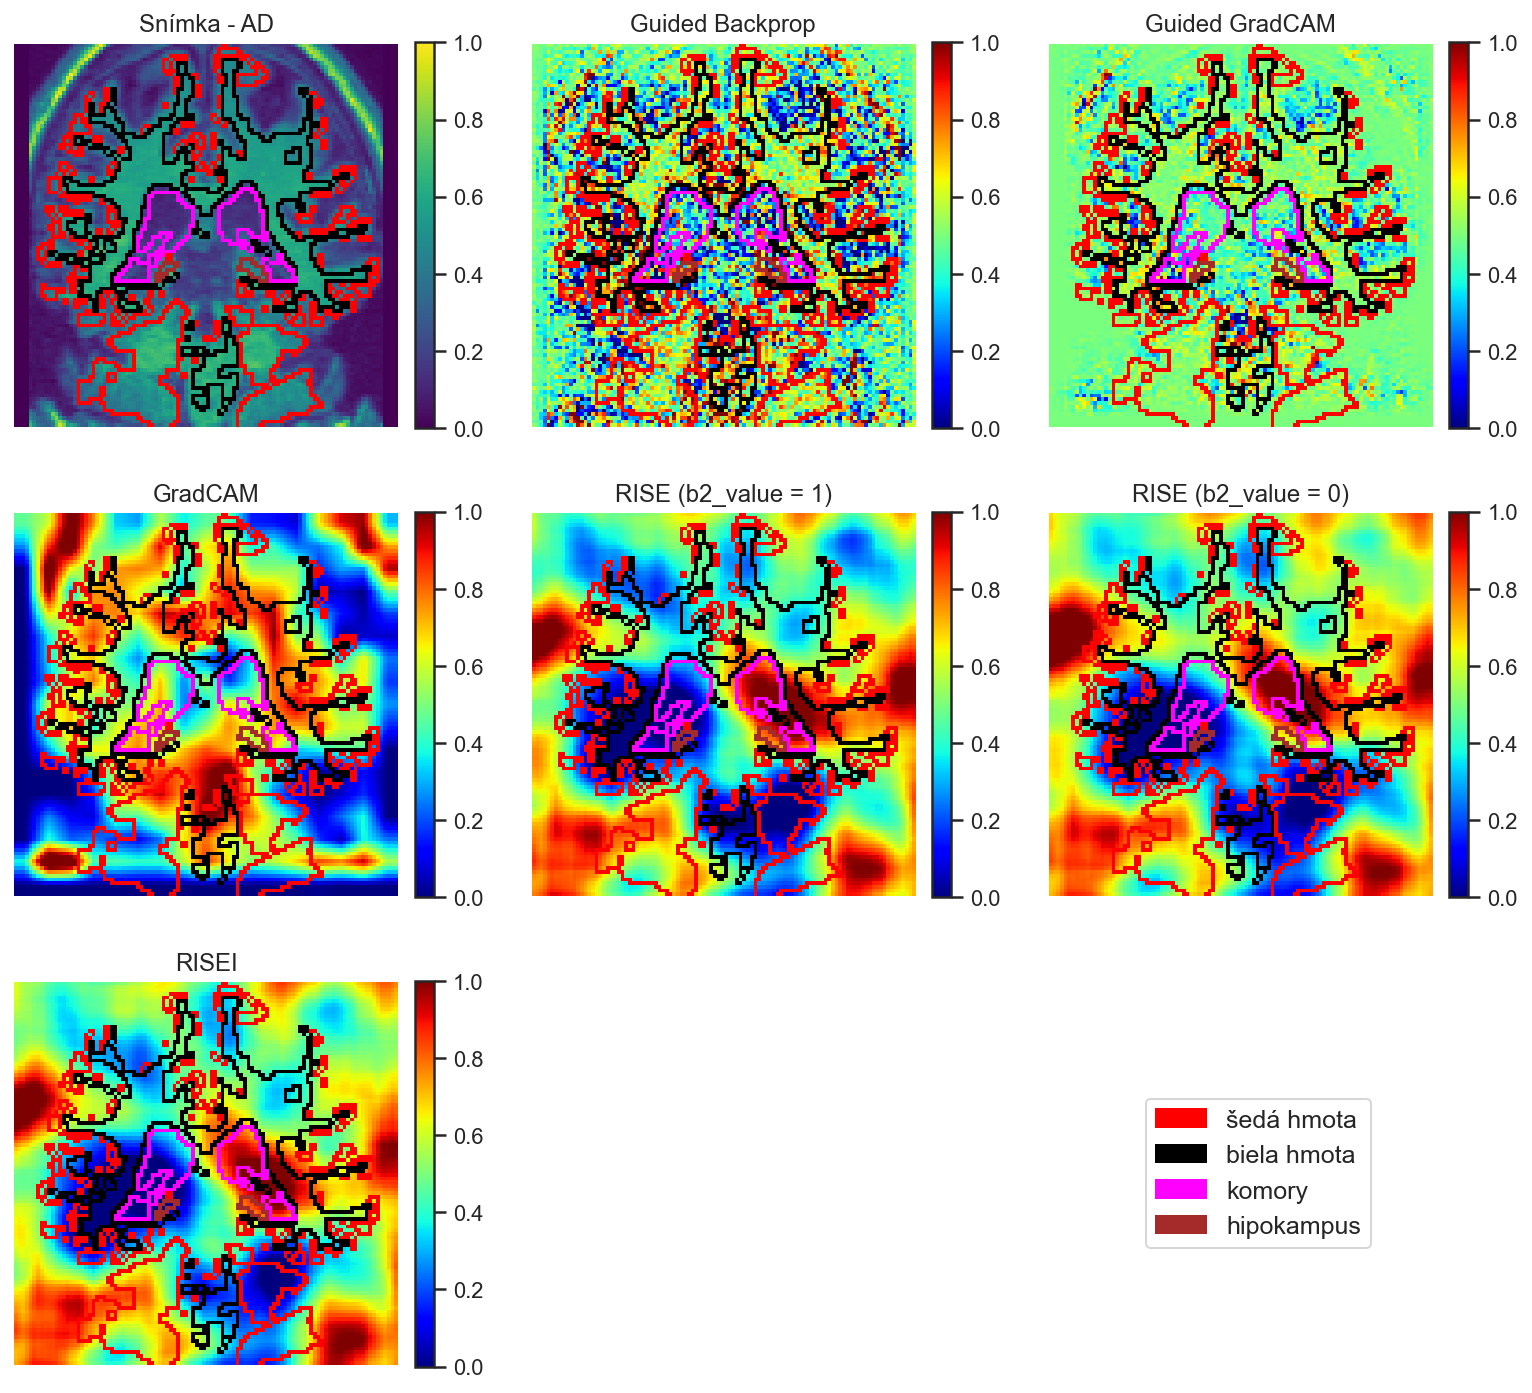

In [29]:
import tensorflow.keras.backend as K

IMAGE_IDX = 4
IMAGE_IDX = 9

def norm(arr):
    x = np.array(arr).copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    return x

def imshow(ax, eval_idx, img_idx, no_heatmap=False):
    ax.set_axis_off()
    
    seg_mask, seg_label, image_x, image_y, heatmap, image_y_pred = evaluators[eval_idx].images[img_idx]

    if no_heatmap:
        alpha = 1
    else:
        alpha = 0
    
    return plot_segmentation(seg_mask, seg_label, image_x, image_y, norm(heatmap), 
                            dim_selector_factory(y=50), alpha=alpha, edges=True,
                            show_image=True, show_heatmap=True, hmap_imshow=hmap_imshow_factory(False, colorbar=False),
                            rotate_angle=2, legend=False, ax=ax)

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(11, 10))
fig.tight_layout()
ax = axes.ravel()
            
_, _, _, image_y, _, _ = evaluators[0].images[IMAGE_IDX]
imshow(ax[0], 0, IMAGE_IDX, no_heatmap=True)
diagnosis = 'AD' if image_y[0] else 'CN'
ax[0].set_title(f'Snímka - {diagnosis}')

imshow(ax[1], 0, IMAGE_IDX)
ax[1].set_title(f'Guided Backprop')

imshow(ax[2], 1, IMAGE_IDX)
ax[2].set_title(f'Guided GradCAM')

imshow(ax[3], 2, IMAGE_IDX)
ax[3].set_title(f'GradCAM')

imshow(ax[4], 3, IMAGE_IDX)
ax[4].set_title(f'RISE (b2_value = 1)')

imshow(ax[5], 4, IMAGE_IDX)
ax[5].set_title(f'RISE (b2_value = 0)')

_, handles = imshow(ax[6], 5, IMAGE_IDX)
ax[6].set_title(f'RISEI')

# imshow(ax[7], 6, IMAGE_IDX)
# ax[7].set_title(f'Guided RISE (b2_value = 1)')

ax[8].set_axis_off()
ax[7].set_axis_off()

norm = colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), fraction=0.046, pad=0.04, ax=ax[0])

for idx in [1, 2, 3, 4, 5, 6]:
# for idx in [2, 4, 5]:
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'), fraction=0.046, pad=0.04, ax=ax[idx])
    
ax[8].legend(handles=handles, loc='center', fontsize='small')

[0. 1.]


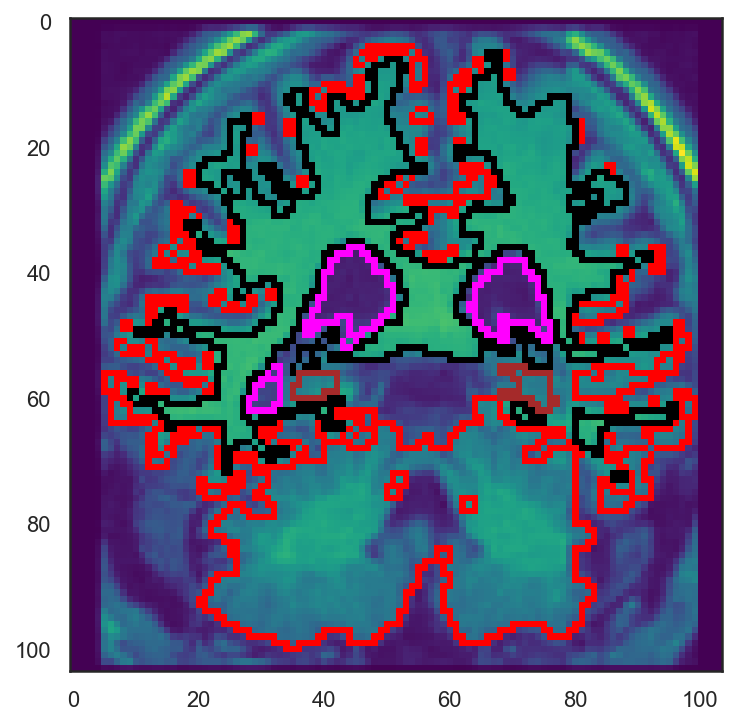

In [30]:
seg_mask, seg_label, image_x, image_y, heatmap, image_y_pred = evaluators[5].images[20]
print(image_y)

fig = plot_segmentation(seg_mask, seg_label, image_x, image_y, heatmap, 
                        dim_selector_factory(y=50), alpha=1, edges=True,
                        show_image=True, show_heatmap=False, hmap_imshow=hmap_imshow_factory(False),
                        rotate_angle=2, legend=False)

In [ ]:
# TODO: https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient